# Castile and Leon: Crops

### Description:
TODO

### Author:
Sergio García Prado ([garciparedes.me](https://garciparedes.me))

In [1]:
library(readr)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Data Adquisition:

In [2]:
crops.herbaceous.url <- "https://analisis.datosabiertos.jcyl.es/resource/agu2-cspz.csv"
crops.herbaceous.filename <- "herbaceous-crops.csv"
if(!file.exists(crops.herbaceous.filename)){
    download.file(crops.herbaceous.url, destfile = crops.herbaceous.filename, method="auto")
}
crops.herbaceous <- read_csv(crops.herbaceous.filename)

Parsed with column specification:
cols(
  a_o = col_integer(),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  ocupaci_n_primera_regad_o = col_integer(),
  ocupaci_n_primera_secano = col_integer(),
  ocupaciones_asociadas_regad_o = col_character(),
  ocupaciones_asociadas_secano = col_character(),
  ocupaciones_posteriores_regad_o = col_character(),
  ocupaciones_posteriores_secano = col_character()
)


In [3]:
crops.woody.url <- "https://analisis.datosabiertos.jcyl.es/resource/2vwa-si9n.csv"
crops.woody.filename <- "woody-crops.csv"
if(!file.exists(crops.herbaceous.filename)){
    download.file(fileURL, destfile = crops.woody.filename, method="auto")
}
crops.woody <- read_csv(crops.woody.filename)

Parsed with column specification:
cols(
  a_o = col_datetime(format = ""),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  n_total_arboles_diseminados = col_integer(),
  superficie_regad_o_en_producci_n = col_integer(),
  superficie_regad_o_que_no_pruduce = col_integer(),
  superficie_secano_en_producci_n = col_integer(),
  superficie_secano_que_no_pruduce = col_integer()
)


## Data Exploration:

In [4]:
colnames(crops.herbaceous)

[1] "a_o"                             "codigo_comarca"                 
 [3] "codigo_muncipio"                 "codigo_producto"                
 [5] "codigo_provincia"                "comarca"                        
 [7] "cultivo"                         "grupo_de_cultivo"               
 [9] "municipio"                       "ocupaci_n_primera_regad_o"      
[11] "ocupaci_n_primera_secano"        "ocupaciones_asociadas_regad_o"  
[13] "ocupaciones_asociadas_secano"    "ocupaciones_posteriores_regad_o"
[15] "ocupaciones_posteriores_secano"

#### Remove Empty Columns

In [5]:
crops.herbaceous <- crops.herbaceous %>%
    select(a_o:ocupaci_n_primera_secano)

#### View Data Sample

In [6]:
sample_n(crops.herbaceous, 10)

a_o,codigo_comarca,codigo_muncipio,codigo_producto,codigo_provincia,comarca,cultivo,grupo_de_cultivo,municipio,ocupaci_n_primera_regad_o,ocupaci_n_primera_secano
2010,3,24,0001/02,5,BARCO AVILA-PIEDRAHITA,CEBADA,CEREALES GRANO,BECEDAS,1,1
2010,2,61,0001/01,5,AVILA,TRIGO,CEREALES GRANO,COLILLA (LA),NA,23
2010,6,132,0003/04,5,VALLE DEL TIETAR,PATATA TARDIA,TUBERCULOS,MOMBELTRAN,1,NA
2010,6,127,0001/04,5,VALLE DEL TIETAR,CENTENO,CEREALES GRANO,MIJARES,NA,3
2010,1,69,0006/01,5,AREVALO-MADRIGAL,CEREALES PARA FORRAJ,CULTIVOS FORRAJEROS,DONJIMENO,1,1
2010,2,33,0001/02,5,AVILA,CEBADA,CEREALES GRANO,BLASCOMILLAN,14,402
2010,6,127,0007/11,5,VALLE DEL TIETAR,SANDIA,HORTALIZAS,MIJARES,1,NA
2010,3,7,0002/01,5,BARCO AVILA-PIEDRAHITA,JUDIA SECA,LEGUMINOSAS GRANO,ALDEANUEVA DE SANTA CRUZ,1,NA
2010,1,45,0001/02,5,AREVALO-MADRIGAL,CEBADA,CEREALES GRANO,CABIZUELA,10,183
2010,6,54,0007/11,5,VALLE DEL TIETAR,SANDIA,HORTALIZAS,CASAVIEJA,1,NA


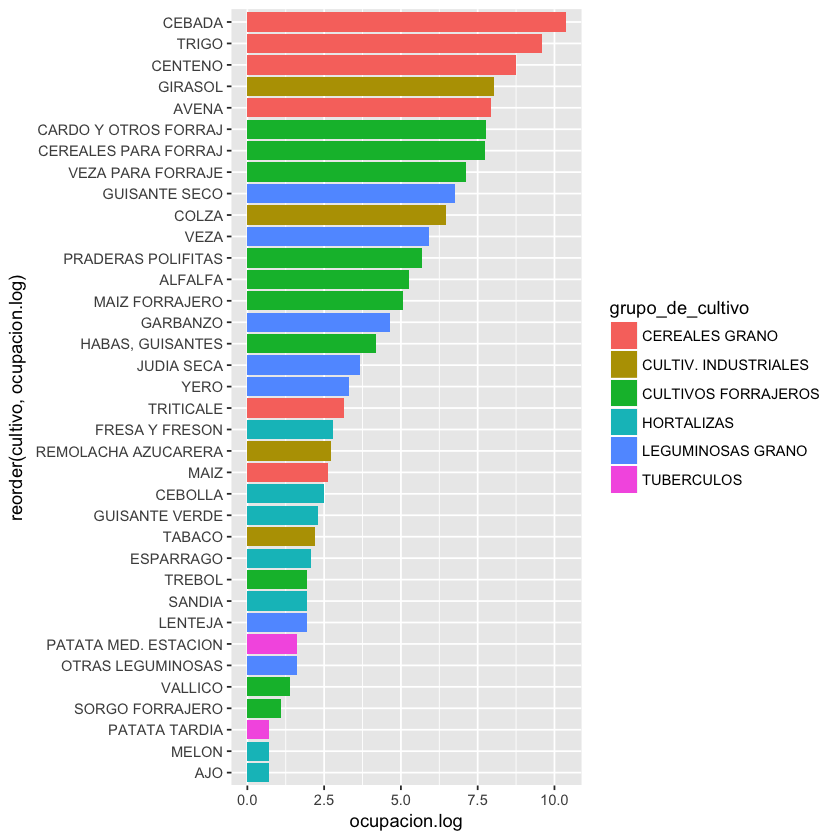

In [7]:
crops.herbaceous %>%
  select(a_o, cultivo, `grupo_de_cultivo`, `ocupaci_n_primera_secano`) %>%
  filter(`ocupaci_n_primera_secano` > 0) %>%
  group_by(`grupo_de_cultivo`, cultivo) %>%
  summarise(ocupacion = sum(`ocupaci_n_primera_secano`, na.rm = TRUE)) %>%
  mutate(ocupacion.log = log(ocupacion)) %>%
  filter(ocupacion.log > 0) %>%
  ggplot(aes(x = reorder(cultivo, ocupacion.log), y = ocupacion.log)) + 
    geom_bar(aes(fill = `grupo_de_cultivo`), stat = "identity") + 
    coord_flip()

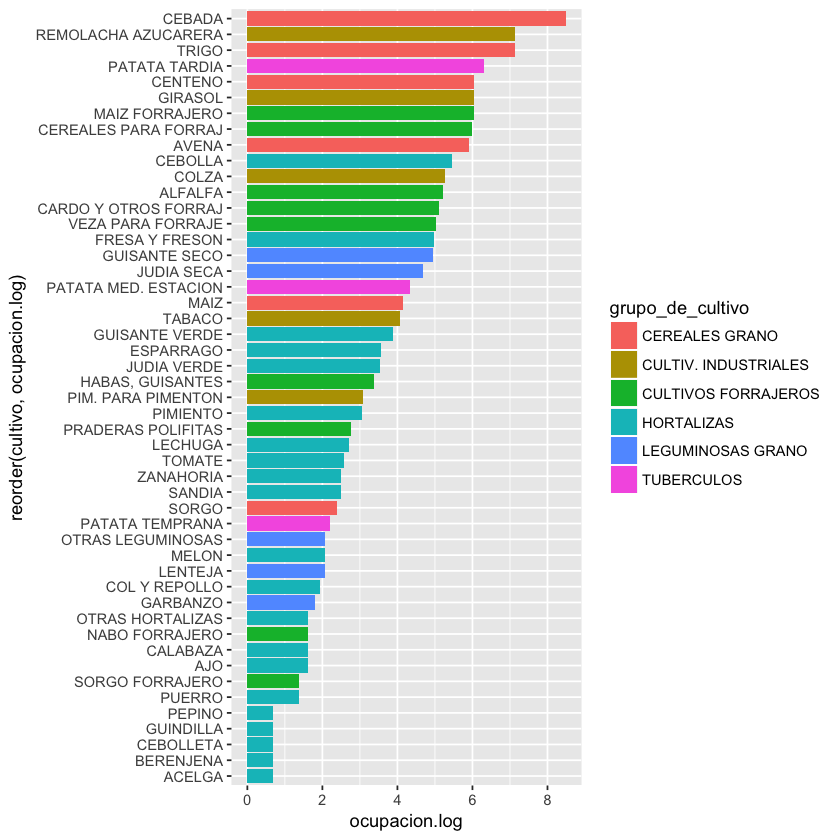

In [8]:
crops.herbaceous %>%
  select(a_o, cultivo, `grupo_de_cultivo`, `ocupaci_n_primera_regad_o`) %>%
  filter(`ocupaci_n_primera_regad_o` > 0) %>%
  group_by(`grupo_de_cultivo`, cultivo) %>%
  summarise(ocupacion = sum(`ocupaci_n_primera_regad_o`, na.rm = TRUE)) %>%
  mutate(ocupacion.log = log(ocupacion)) %>%
  filter(ocupacion.log > 0) %>%
  ggplot(aes(x = reorder(cultivo, ocupacion.log), y = ocupacion.log)) + 
    geom_bar(aes(fill = `grupo_de_cultivo`), stat = "identity") + 
    coord_flip()